In [1]:
from util import read_refdata, symbol_list, \
    Z2Symbol_dict, Symbol2Z_dict
from solrs_plot import AbundPlot
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
import numpy as np
import pandas as pd
from pathlib import Path
from concurrent.futures import ProcessPoolExecutor as Pool
from concurrent.futures import as_completed

import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)
import seaborn as sns
from tqdm import tqdm

exp10 = lambda x: np.power(10, x)
log10 = np.log10
import emcee

def log_prior(theta):
    A, B = theta
    if (np.abs(A) > 20) or (np.abs(B) > 20):
        return -np.inf
    else:
        return 0

def log_likelihood(theta, M_vec_0, M_vec_1, O_vec, eO_vec):
    A, B = theta
    return -np.sum(np.square((
        np.log10(
            np.power(10, A+M_vec_0)+\
            np.power(10, B+M_vec_1)
        )-O_vec)/eO_vec))

def log_probability(theta, M_vec_0, M_vec_1, O_vec, eO_vec):
    lgp = log_prior(theta)
    if np.isfinite(lgp):
        lgl = log_likelihood(theta, M_vec_0, M_vec_1, O_vec, eO_vec)
        return lgl + lgp
    else:
        return -np.inf

def func_A(M_vec, O_vec, eO_vec, flag_adopt=None):
    eM_vec = np.full(M_vec.shape[-1], 0.0)
    flag_detect = (~np.isnan(O_vec)) & (np.isfinite(M_vec))
    if flag_adopt is None:
        flag_adopt = flag_detect
    else:
        flag_adopt = (flag_adopt) & (flag_detect)
    O_vec = O_vec[flag_adopt]
    eO_vec = eO_vec[flag_adopt]
    M_vec = M_vec[flag_adopt]
    eM_vec = eM_vec[flag_adopt]
    
    inv_err2 = 1/(np.square(eO_vec) + np.square(eM_vec))
    sum_inv_err2 = np.sum(inv_err2)
    relative_res = (M_vec - O_vec) * inv_err2
    sum_relres = np.sum(relative_res)
    A = - sum_relres / sum_inv_err2
    return A # - 0.11765639216810353

def func_AB(M_vec_0, M_vec_1, O_vec, eO_vec, flag_adopt=None):
    # eM_vec = np.full(M_vec.shape[-1], 0.0)
    # flag_detect = ~np.isnan(O_vec)
    flag_detect = (~np.isnan(O_vec)) & ((np.isfinite(M_vec_0)) & (np.isfinite(M_vec_1)))
    if flag_adopt is None:
        flag_adopt = flag_detect
    else:
        flag_adopt = (flag_adopt) & (flag_detect)
    O_vec = O_vec[flag_adopt]
    eO_vec = eO_vec[flag_adopt]
    M_vec_0 = M_vec_0[flag_adopt]
    M_vec_1 = M_vec_1[flag_adopt]
    sampler = emcee.EnsembleSampler(30, 2, log_probability, args=(M_vec_0, M_vec_1, O_vec, eO_vec))
    sampler.run_mcmc(np.random.uniform(size=(30, 2)), nsteps=5000, progress=False)
    A, B = np.median(sampler.get_chain(discard=2000).reshape(-1, 2), axis=0)
    log_prob = -sampler.get_log_prob(discard=2500)
    # argmin = np.unravel_index(np.argmin(log_prob, axis=None), log_prob.shape)
    chisqr = log_prob.min()
    # A, B = sampler.get_chain(discard=2500)[argmin]

    return A, B, chisqr# - 0.11765639216810353

# def func_AB_sampler(M_vec_0, M_vec_1, O_vec, eO_vec, flag_adopt=None):
#     # eM_vec = np.full(M_vec.shape[-1], 0.0)
#     # flag_detect = ~np.isnan(O_vec)
#     flag_detect = (~np.isnan(O_vec)) & ((np.isfinite(M_vec_0)) | (np.isfinite(M_vec_1)))
#     if flag_adopt is None:
#         flag_adopt = flag_detect
#     else:
#         flag_adopt = (flag_adopt) & (flag_detect)
#     O_vec = O_vec[flag_adopt]
#     eO_vec = eO_vec[flag_adopt]
#     M_vec_0 = M_vec_0[flag_adopt]
#     M_vec_1 = M_vec_1[flag_adopt]
#     sampler = emcee.EnsembleSampler(30, 2, log_probability, args=(M_vec_0, M_vec_1, O_vec, eO_vec))
#     sampler.run_mcmc(np.random.uniform(size=(30, 2)), nsteps=5000, progress=False)
#     return sampler

In [2]:
aplt = AbundPlot(datafile='J0804+5740.csv')
star_name = 'J0804+5740'
aplt.load_star(star_name)
O_vec = np.full(len(symbol_list), np.nan, dtype=np.float64)
eO_vec = np.full(len(symbol_list), np.nan, dtype=np.float64)
for key in aplt.star_logeps_dict:
    O_vec[Symbol2Z_dict[key]-1] = aplt.star_logeps_dict[key]
    eO_vec[Symbol2Z_dict[key]-1] = aplt.star_elogeps_dict[key]
eM_vec = np.zeros(len(symbol_list))
flag_adopt_light = np.arange(len(O_vec)) < 30
flag_adopt_heavy = np.arange(len(O_vec)) >= 30

In [16]:
nfrac_list = []
nfrac_sols = read_refdata('/home/jiangrz/ssd/GitHub/rproc/data/sne/prantzos2020/s_component.dat')[1]
nfrac_solr = read_refdata('/home/jiangrz/ssd/GitHub/rproc/data/sne/prantzos2020/r_component.dat')[1]
M_sols = np.log10(nfrac_sols)
M_solr = np.log10(nfrac_solr)
flag_detect = (~np.isnan(O_vec)) & (np.isfinite(M_solr)) & (np.isfinite(M_sols))
A, B, chisqr_red_sol_rs = func_AB(M_solr, M_sols, O_vec, eO_vec, flag_adopt_heavy)
chisqr_red_sol_rs /= (np.sum(flag_adopt_heavy & flag_detect)-1)
print(chisqr_red_sol_rs)
progenitor_solr = A + M_solr
progenitor_sols = B + M_sols
progenitor_solrs = np.log10(np.power(10, progenitor_solr)+np.power(10, progenitor_sols))
portion_r = 1/(np.power(10, A)/np.power(10, B)+1)
portion_s = 1/(np.power(10, B)/np.power(10, A)+1)
# print(P_m[np.argmin(chisqr_arr)])

1.2420893165197817


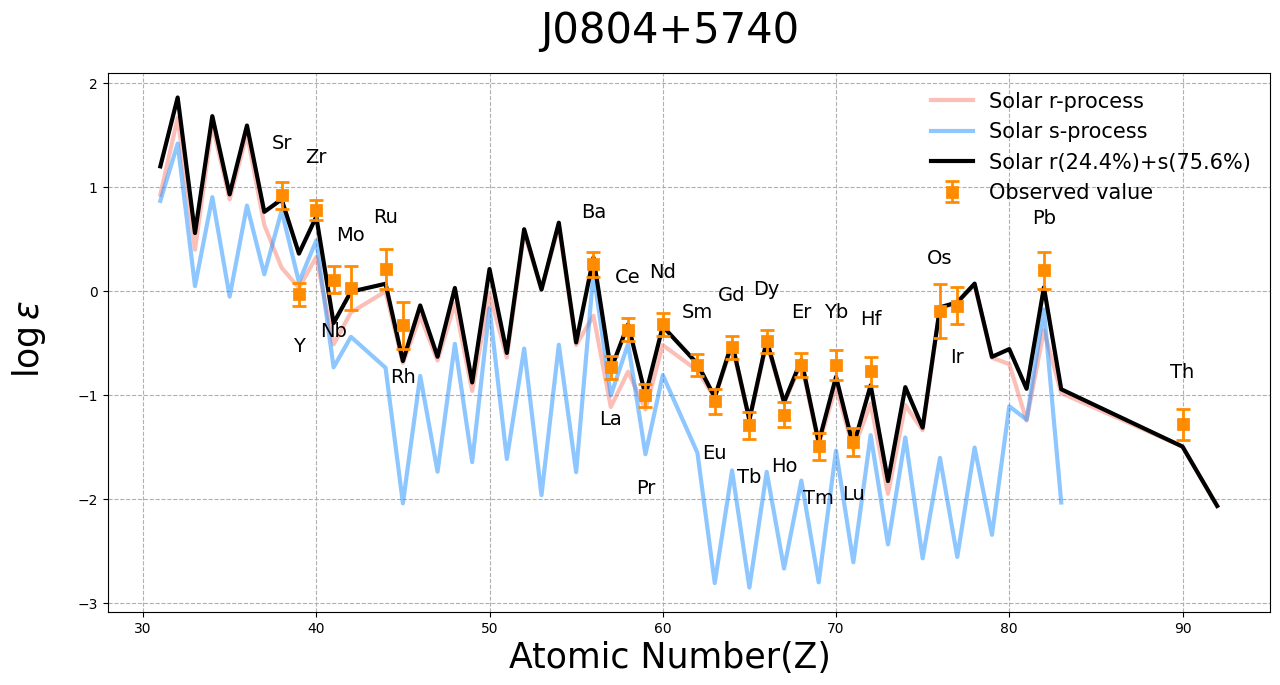

In [17]:
fig, ax = plt.subplots(
    1, 1, figsize=(15, 7), 
    # height_ratios=(2, .9), 
    dpi=100, sharex=False)
# fig.subplots_adjust(hspace=.1)
Z_arr = np.array([Symbol2Z_dict[symbol] for symbol in symbol_list])
ax.plot(
    Z_arr[np.isfinite(progenitor_solr)&flag_adopt_heavy], 
    progenitor_solr[np.isfinite(progenitor_solr)&flag_adopt_heavy], 
    linewidth=3, c='salmon', alpha=.5, 
    # label='Solar r-process (scaled to Eu)', 
    label='Solar r-process', 
    zorder=2)
ax.plot(
    Z_arr[np.isfinite(progenitor_sols)&flag_adopt_heavy], 
    progenitor_sols[np.isfinite(progenitor_sols)&flag_adopt_heavy], 
    linewidth=3, c='dodgerblue', alpha=.5, 
    # label='Solar s-process (scaled to Ba)', 
    label='Solar s-process', 
    zorder=2)
ax.plot(
    Z_arr[np.isfinite(progenitor_solrs)&flag_adopt_heavy], 
    progenitor_solrs[np.isfinite(progenitor_solrs)&flag_adopt_heavy], 
    linewidth=3, c='k', # alpha=.5, 
    label='Solar r(%.1f%%)+s(%.1f%%)'%(portion_r*100, portion_s*100), 
    # label='Solar r+s', 
    zorder=2)
ec = 'darkorange'
ew = 2
ax.errorbar(
    Z_arr[flag_adopt_heavy], O_vec[flag_adopt_heavy], yerr=eO_vec[flag_adopt_heavy],
    ecolor=ec, elinewidth=ew, linestyle='', capsize=5, capthick=3,
    marker='s', markersize=7, mfc='darkorange', mec=ec, mew=ew,
    label='Observed value', 
    alpha=1, zorder=10)
for _idx, (_x, _y) in enumerate(zip(Z_arr[flag_adopt_heavy], O_vec[flag_adopt_heavy])):
    if np.isnan(_y):
        continue
    _t = Z2Symbol_dict[_x]
    sign_pos = +1
    if _x % 2 == 1:
        sign_pos = -1
    _y += (sign_pos * .5)
    if _t == 'Pr':
        _y -= .4
    ax.text(_x, _y, _t, ha='center', va='center', fontsize=14, zorder=5)
ax.grid(True, linestyle='--', alpha=1, zorder=1)
ax.legend(loc='best', fontsize=15, frameon=False)
fig.supxlabel("Atomic Number(Z)", size=25, y=.02)
fig.supylabel(r'$\log\varepsilon$', size=25, x=.06)
fig.suptitle(star_name, y=.97, size=30)
plt.show();

In [5]:
nfrac_list = []
for path in Path('/home/jiangrz/ssd/GitHub/rproc/data/sne/nst2017').iterdir():
    if path.suffix == '.dat':
        mfrac, nfrac = read_refdata(path)
        nfrac_list.append(nfrac)
        # break
M_mrsn = np.log10(np.array(nfrac_list))
M_mrsn = M_mrsn - M_mrsn[:, [0]] + 12 # - M[:, [25]]

nfrac_list = []
P_list = []
for path in Path('/home/jiangrz/ssd/GitHub/rproc/data/sne/hw2010').iterdir():
    if path.suffix == '.dat':
        mfrac, nfrac = read_refdata(path)
        nfrac_list.append(nfrac)
        # break
        P_vec = np.array([path.stem[:4], path.stem[4:7], path.stem[7:]], dtype=np.float64)
        P_vec /= 10
        P_list.append(P_vec)
M_ccsn = np.log10(np.array(nfrac_list))
M_ccsn = M_ccsn - M_ccsn[:, [0]] + 12 # - M[:, [25]]
P_ccsn = np.array(P_list)

nfrac_list = []
P_list = []
for path in Path('/home/jiangrz/ssd/GitHub/rproc/data/sne/just2015').iterdir():
    if path.suffix == '.dat':
        mfrac, nfrac = read_refdata(path)
        nfrac_list.append(nfrac)
        # break
        P_vec = np.array([path.stem[:2], path.stem[2:6], path.stem[6:]], dtype=np.float64)
        # break
        P_vec[1] /= 10000
        P_vec[2] /= 10
        P_list.append(P_vec)
M_nsm = np.log10(np.array(nfrac_list))
M_nsm = M_nsm - M_nsm[:, [0]] + 12 # - M[:, [25]]
P_nsm = np.array(P_list)

nfrac_list = []
P_list = []
for path in Path('/home/jiangrz/ssd/GitHub/rproc/data/sne/bisterzo2010').iterdir():
    if path.suffix == '.dat':
        mfrac, nfrac = read_refdata(path)
        nfrac_list.append(nfrac)
        # break
        P_vec = np.array([path.stem[:2], path.stem[4], path.stem[6:]], dtype=np.float64)
        # break
        P_vec[0] *= (-.1)
        P_vec[1] = 1/P_vec[1]
        P_vec[2] /= 10
        P_list.append(P_vec)
M_agb = np.log10(np.array(nfrac_list))
M_agb = M_agb - M_agb[:, [0]] + 12# - M[:, [25]]
P_agb = np.array(P_list)

solmfrac, solnfrac = read_refdata('/home/jiangrz/ssd/GitHub/rproc/data/ref/sol_asplund09.dat')
solref = np.log10(solnfrac)
solref = solref - solref[0] + 12

In [6]:
chisqr_list = []
for M_vec in M_ccsn:
    A = func_A(M_vec, O_vec, eO_vec, flag_adopt_light)
    flag_detect = (~np.isnan(O_vec)) & (np.isfinite(M_vec))
    AmM2_vec = np.power(A + M_vec[flag_adopt_light & flag_detect] - O_vec[flag_adopt_light & flag_detect], 2)
    eAmM2_vec = np.power(eM_vec[flag_adopt_light & flag_detect], 2) + np.power(eO_vec[flag_adopt_light & flag_detect], 2)
    chisqr = np.sum(AmM2_vec/eAmM2_vec)
    chisqr_list.append(chisqr)
chisqr_arr = np.array(chisqr_list)
chisqr_red_ccsn = np.min(chisqr_arr)/(np.sum(flag_adopt_light & flag_detect)-1)
print(chisqr_red_ccsn)
progenitor_ccsn = M_ccsn[np.argmin(chisqr_arr), :]
A_ccsn = func_A(progenitor_ccsn, O_vec, eO_vec, flag_adopt_light)
progenitor_ccsn += A_ccsn
# print(P_ccsn[np.argmin(chisqr_arr)])

chisqr_list = []
for M_vec in M_mrsn:
    A = func_A(M_vec, O_vec, eO_vec, flag_adopt_heavy)
    flag_detect = (~np.isnan(O_vec)) & (np.isfinite(M_vec))
    AmM2_vec = np.power(A + M_vec[flag_adopt_heavy & flag_detect] - O_vec[flag_adopt_heavy & flag_detect], 2)
    eAmM2_vec = np.power(eM_vec[flag_adopt_heavy & flag_detect], 2) + np.power(eO_vec[flag_adopt_heavy & flag_detect], 2)
    chisqr = np.sum(AmM2_vec/eAmM2_vec)
    chisqr_list.append(chisqr)
chisqr_arr = np.array(chisqr_list)
chisqr_red_mrsn = np.min(chisqr_arr)/(np.sum(flag_adopt_heavy & flag_detect)-1)
print(chisqr_red_mrsn)
progenitor_mrsn = M_mrsn[np.argmin(chisqr_arr), :]
A_choice = func_A(progenitor_mrsn, O_vec, eO_vec, flag_adopt_heavy)
progenitor_mrsn += A_choice
# print(P_m[np.argmin(chisqr_arr)])

chisqr_list = []
for M_vec in M_nsm:
    A = func_A(M_vec, O_vec, eO_vec, flag_adopt_heavy)
    flag_detect = (~np.isnan(O_vec)) & (np.isfinite(M_vec))
    AmM2_vec = np.power(A + M_vec[flag_adopt_heavy & flag_detect] - O_vec[flag_adopt_heavy & flag_detect], 2)
    eAmM2_vec = np.power(eM_vec[flag_adopt_heavy & flag_detect], 2) + np.power(eO_vec[flag_adopt_heavy & flag_detect], 2)
    chisqr = np.sum(AmM2_vec/eAmM2_vec)
    chisqr_list.append(chisqr)
chisqr_arr = np.array(chisqr_list)
chisqr_red_nsm = np.min(chisqr_arr)/(np.sum(flag_adopt_heavy & flag_detect)-1)
print(chisqr_red_nsm)
progenitor_nsm = M_nsm[np.argmin(chisqr_arr), :]
A_nsm = func_A(progenitor_nsm, O_vec, eO_vec, flag_adopt_heavy)
progenitor_nsm += A_nsm
# print(P_nsm[np.argmin(chisqr_arr)])

M_choice_ccsn_mrsn = np.full(len(symbol_list), np.nan, dtype=np.float64)
M_choice_ccsn_mrsn[flag_adopt_light] = progenitor_mrsn[flag_adopt_light]
M_choice_ccsn_mrsn[flag_adopt_heavy] = progenitor_mrsn[flag_adopt_heavy]
M_choice_ccsn_nsm = np.full(len(symbol_list), np.nan, dtype=np.float64)
M_choice_ccsn_nsm[flag_adopt_light] = progenitor_nsm[flag_adopt_light]
M_choice_ccsn_nsm[flag_adopt_heavy] = progenitor_nsm[flag_adopt_heavy]

8.073726145528621
10.8838896894039
13.878665735041931


In [7]:
M_A = M_mrsn
M_B = M_agb
# M_B = np.concatenate((M_agb, M_agb))
chisqr_arr = np.full((len(M_A), len(M_B)), np.inf)
A_arr = np.full((len(M_A), len(M_B)), np.inf)
B_arr = np.full((len(M_A), len(M_B)), np.inf)
pbar = tqdm(total=len(M_A)*len(M_B))
futures = {}
with Pool(max_workers=30) as pool:
    for idx_0, M_vec_0 in enumerate(M_A):
        for idx_1, M_vec_1 in enumerate(M_B):
            future = pool.submit(
                func_AB, 
                M_vec_0, M_vec_1, O_vec, eO_vec, flag_adopt_heavy)
            future.add_done_callback(lambda p:pbar.update())
            futures.update({'%03d_%02d'%(idx_0, idx_1): future})
pbar.close()

flag_detect = (~np.isnan(O_vec)) & (np.isfinite(M_vec_0)) & (np.isfinite(M_vec_1))
# flag_detect = (~np.isnan(O_vec)) & ((np.isfinite(M_vec_0)) | (np.isfinite(M_vec_1)))
# flag_detect = ~np.isnan(O_vec)
for key in futures:
    idx_0, idx_1 = key.split('_')
    idx_0 = int(idx_0)
    idx_1 = int(idx_1)
    A, B, chisqr = futures[key].result()
    A_arr[idx_0, idx_1] = A
    B_arr[idx_0, idx_1] = B
    chisqr_arr[idx_0, idx_1] = chisqr
arg_min = np.unravel_index(np.argmin(chisqr_arr, axis=None), chisqr_arr.shape)
A = A_arr[arg_min]
B = B_arr[arg_min]
chisqr_red_mrsn_agb = chisqr_arr[arg_min]/(np.sum(flag_adopt_heavy & flag_detect)-1)
progenitor_mrsn_agb = np.log10(np.power(10, A+M_A[arg_min[0]])+np.power(10, B+M_B[arg_min[1]]))

100%|██████████| 54/54 [00:11<00:00,  4.79it/s]


In [8]:
M_A = M_nsm
M_B = M_agb
# M_B = np.concatenate((M_agb, M_agb))
chisqr_arr = np.full((len(M_A), len(M_B)), np.inf)
A_arr = np.full((len(M_A), len(M_B)), np.inf)
B_arr = np.full((len(M_A), len(M_B)), np.inf)
pbar = tqdm(total=len(M_A)*len(M_B))
futures = {}
with Pool(max_workers=30) as pool:
    for idx_0, M_vec_0 in enumerate(M_A):
        for idx_1, M_vec_1 in enumerate(M_B):
            future = pool.submit(
                func_AB, 
                M_vec_0, M_vec_1, O_vec, eO_vec, flag_adopt_heavy)
            future.add_done_callback(lambda p:pbar.update())
            futures.update({'%d_%d'%(idx_0, idx_1): future})
pbar.close()

# flag_detect = (~np.isnan(O_vec)) & ((np.isfinite(M_vec_0)) | (np.isfinite(M_vec_1)))
flag_detect = (~np.isnan(O_vec)) & ((np.isfinite(M_vec_0)) & (np.isfinite(M_vec_1)))
# flag_detect = ~np.isnan(O_vec)
for key in futures:
    idx_0, idx_1 = key.split('_')
    idx_0 = int(idx_0)
    idx_1 = int(idx_1)
    A, B, chisqr = futures[key].result()
    A_arr[idx_0, idx_1] = A
    B_arr[idx_0, idx_1] = B
    chisqr_arr[idx_0, idx_1] = chisqr
arg_min = np.unravel_index(np.argmin(chisqr_arr, axis=None), chisqr_arr.shape)
A = A_arr[arg_min]
B = B_arr[arg_min]
chisqr_red_nsm_agb = chisqr_arr[arg_min]/(np.sum(flag_adopt_heavy & flag_detect)-1)
progenitor_nsm_agb = np.log10(np.power(10, A+M_A[arg_min[0]])+np.power(10, B+M_B[arg_min[1]]))

100%|██████████| 1596/1596 [04:55<00:00,  5.39it/s]


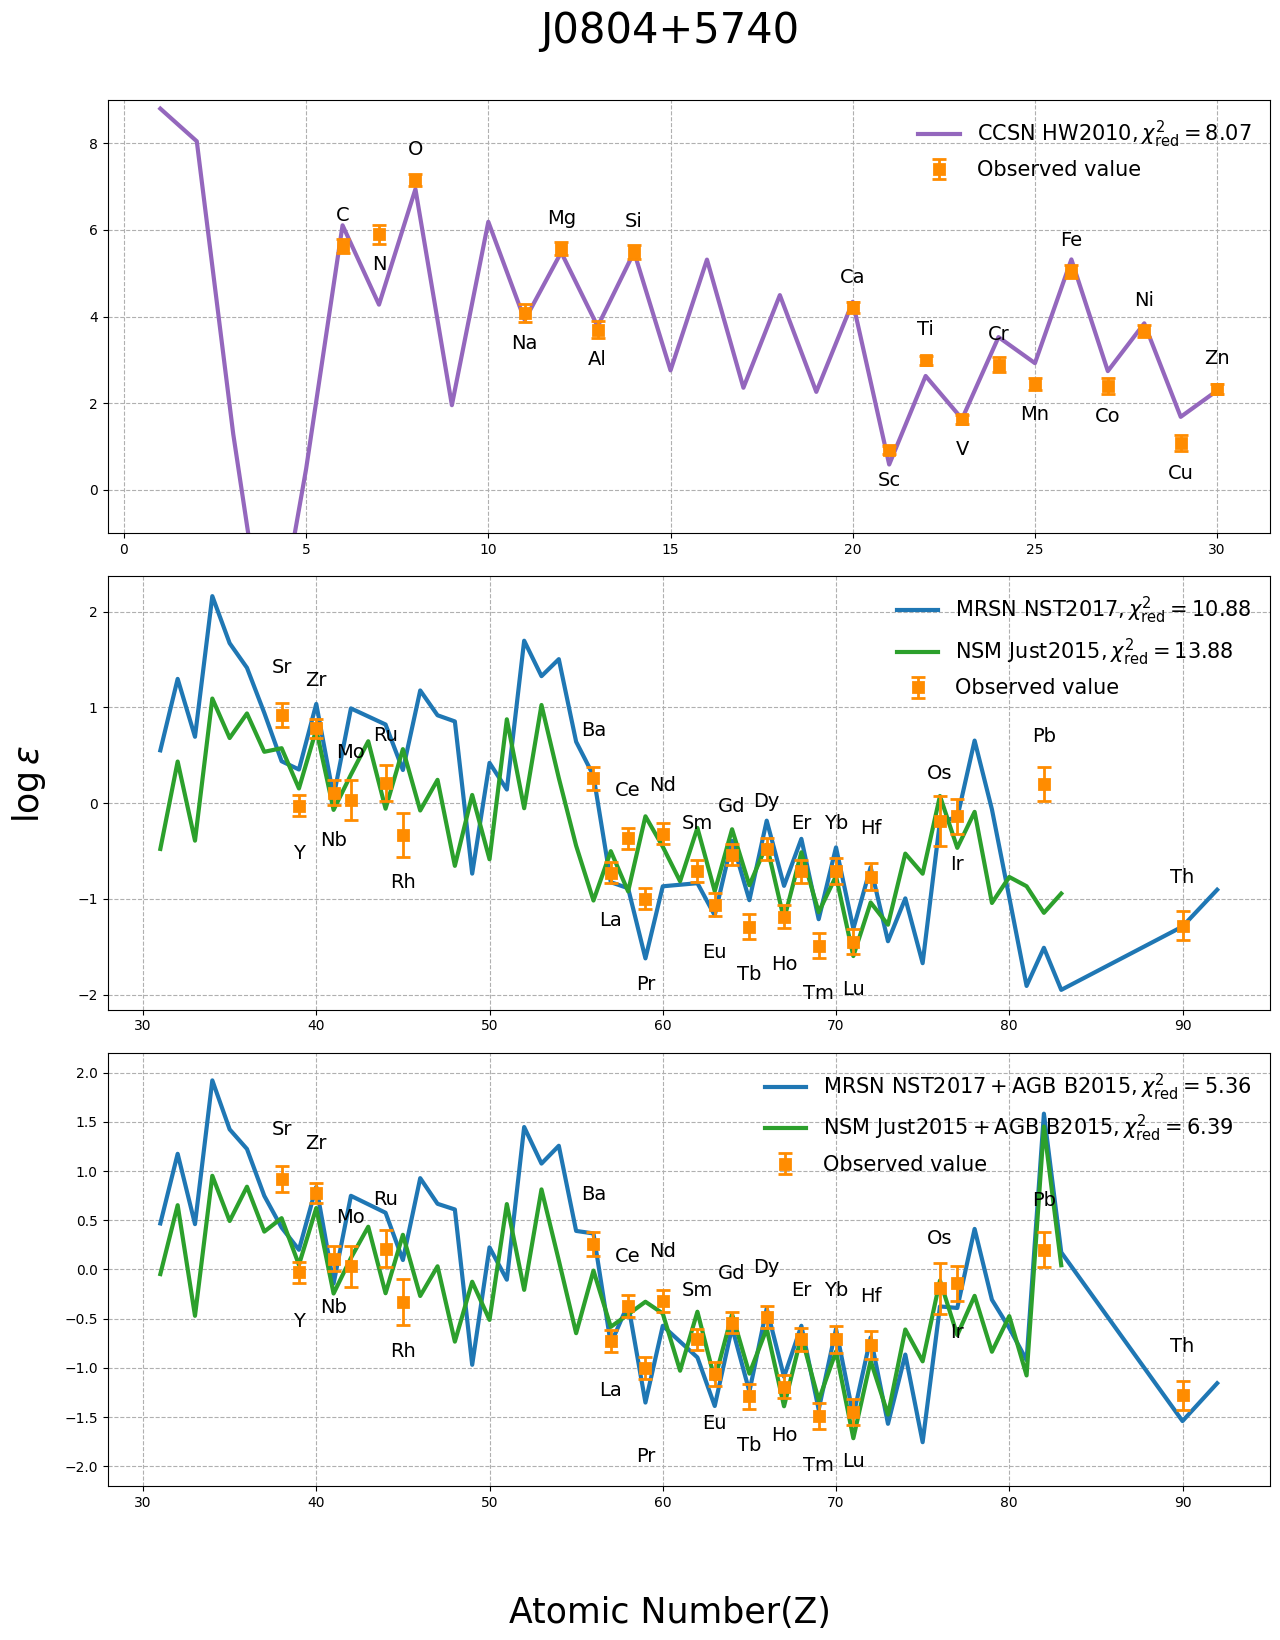

In [10]:
fig, axes = plt.subplots(
    3, 1, figsize=(15, 18), 
    # height_ratios=(2, .9), 
    dpi=100, sharex=False)
fig.subplots_adjust(hspace=.1)
Z_arr = np.array([Symbol2Z_dict[symbol] for symbol in symbol_list])
# ax.plot(
#     Z_arr[np.isfinite(M_choice)], 
#     M_choice[np.isfinite(M_choice)], 
#     linewidth=3, c='black', alpha=.9, 
#     label="MRCC NST2017", 
#     zorder=2)
axes[0].plot(
    Z_arr[np.isfinite(progenitor_ccsn)&flag_adopt_light], 
    progenitor_ccsn[np.isfinite(progenitor_ccsn)&flag_adopt_light], 
    linewidth=3, c='C4', # alpha=.5, 
    label=r"$\mathrm{CCSN\ HW2010}, \chi^2_\mathrm{red}=%.2f$"%chisqr_red_ccsn, 
    zorder=2)
axes[1].plot(
    Z_arr[np.isfinite(progenitor_mrsn)&flag_adopt_heavy], 
    progenitor_mrsn[np.isfinite(progenitor_mrsn)&flag_adopt_heavy], 
    linewidth=3, c='C0', # alpha=.5, 
    label=r"$\mathrm{MRSN\ NST2017}, \chi^2_\mathrm{red}=%.2f$"%chisqr_red_mrsn, 
    zorder=2)
axes[1].plot(
    Z_arr[np.isfinite(progenitor_nsm)&flag_adopt_heavy], 
    progenitor_nsm[np.isfinite(progenitor_nsm)&flag_adopt_heavy], 
    linewidth=3, c='C2', # alpha=.5, 
    label=r"$\mathrm{NSM\ Just2015}, \chi^2_\mathrm{red}=%.2f$"%chisqr_red_nsm,
    zorder=2)
axes[2].plot(
    Z_arr[np.isfinite(progenitor_mrsn_agb)&flag_adopt_heavy], 
    progenitor_mrsn_agb[np.isfinite(progenitor_mrsn_agb)&flag_adopt_heavy], 
    linewidth=3, c='C0', # alpha=.5, 
    label=r"$\mathrm{MRSN\ NST2017}+\mathrm{AGB\ B2015}, \chi^2_\mathrm{red}=%.2f$"%(chisqr_red_mrsn_agb), 
    zorder=2)
# axes[2].plot(
#     Z_arr, progenitor_mrsn_agb
# )
axes[2].plot(
    Z_arr[np.isfinite(progenitor_nsm_agb)&flag_adopt_heavy], 
    progenitor_nsm_agb[np.isfinite(progenitor_nsm_agb)&flag_adopt_heavy], 
    linewidth=3, c='C2', # alpha=.5, 
    label=r"$\mathrm{NSM\ Just2015}+\mathrm{AGB\ B2015}, \chi^2_\mathrm{red}=%.2f$"%(chisqr_red_nsm_agb), 
    zorder=2)
ec = 'darkorange'
ew = 2
flag_adopt_list = [flag_adopt_light, flag_adopt_heavy, flag_adopt_heavy]
dist_list = [.7, .5, .5]
for ax, flag_adopt, dist in zip(axes, flag_adopt_list, dist_list):
    ax.errorbar(
        Z_arr[flag_adopt], O_vec[flag_adopt], yerr=eO_vec[flag_adopt],
        ecolor=ec, elinewidth=ew, linestyle='', capsize=5, capthick=3,
        marker='s', markersize=7, mfc='darkorange', mec=ec, mew=ew,
        label='Observed value', 
        alpha=1, zorder=10)
    for _idx, (_x, _y) in enumerate(zip(Z_arr[flag_adopt], O_vec[flag_adopt])):
        if np.isnan(_y):
            continue
        _t = Z2Symbol_dict[_x]
        sign_pos = +1
        if _x % 2 == 1:
            sign_pos = -1
        _y += (sign_pos * dist)
        if _t == 'Pr':
            _y -= .4
        ax.text(_x, _y, _t, ha='center', va='center', fontsize=14, zorder=5)
    ax.grid(True, linestyle='--', alpha=1, zorder=1)
    ax.legend(loc='best', fontsize=15, frameon=False)
axes[0].set_ylim(-1 ,9)
axes[2].set_ylim(-2.2 ,2.2)
fig.supxlabel("Atomic Number(Z)", size=25, y=.03)
fig.supylabel(r'$\log\varepsilon$', size=25, x=.06)
# # axes[1].set_ylabel(r'$\Delta$ log $\varepsilon$', fontdict={'size': 25})
# # axes[1].set_ylabel(r'$|\Delta\log\varepsilon|/\sigma$', fontdict={'size': 30})
fig.suptitle(star_name, y=.93, size=30)
# if fname is not None:
#     fig.savefig(fname, **kw)
# plt.close()
plt.show();

In [15]:
P_agb[arg_min[1]]

array([-3.6,  1. ,  1.5])